In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
import os

In [3]:
# Step 1: Load the dataset

file_path = "/content/drive/MyDrive/Data Science Projects/App/app/static/2010-capitalbikeshare-tripdata.csv"
data = pd.read_csv(file_path)
output_path = "/content/drive/MyDrive/Data Science Projects/App/app/static"
os.makedirs(output_path, exist_ok=True)

In [4]:
# Step 2: Explore the data

print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nData Description:\n", data.describe())

Data Head:
    Duration           Start date             End date  Start station number  \
0      1012  2010-09-20 11:27:04  2010-09-20 11:43:56                 31208   
1        61  2010-09-20 11:41:22  2010-09-20 11:42:23                 31209   
2      2690  2010-09-20 12:05:37  2010-09-20 12:50:27                 31600   
3      1406  2010-09-20 12:06:05  2010-09-20 12:29:32                 31600   
4      1413  2010-09-20 12:10:43  2010-09-20 12:34:17                 31100   

                   Start station  End station number  \
0       M St & New Jersey Ave SE               31108   
1                 1st & N St  SE               31209   
2                  5th & K St NW               31100   
3                  5th & K St NW               31602   
4  19th St & Pennsylvania Ave NW               31201   

                     End station Bike number Member type  
0                  4th & M St SW      W00742      Member  
1                 1st & N St  SE      W00032      Member  

In [5]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")


Column Details:
Column: Duration, Type: int64, Unique values: 8175
Column: Start date, Type: object, Unique values: 113854
Column: End date, Type: object, Unique values: 113546
Column: Start station number, Type: int64, Unique values: 106
Column: Start station, Type: object, Unique values: 106
Column: End station number, Type: int64, Unique values: 107
Column: End station, Type: object, Unique values: 107
Column: Bike number, Type: object, Unique values: 959
Column: Member type, Type: object, Unique values: 3


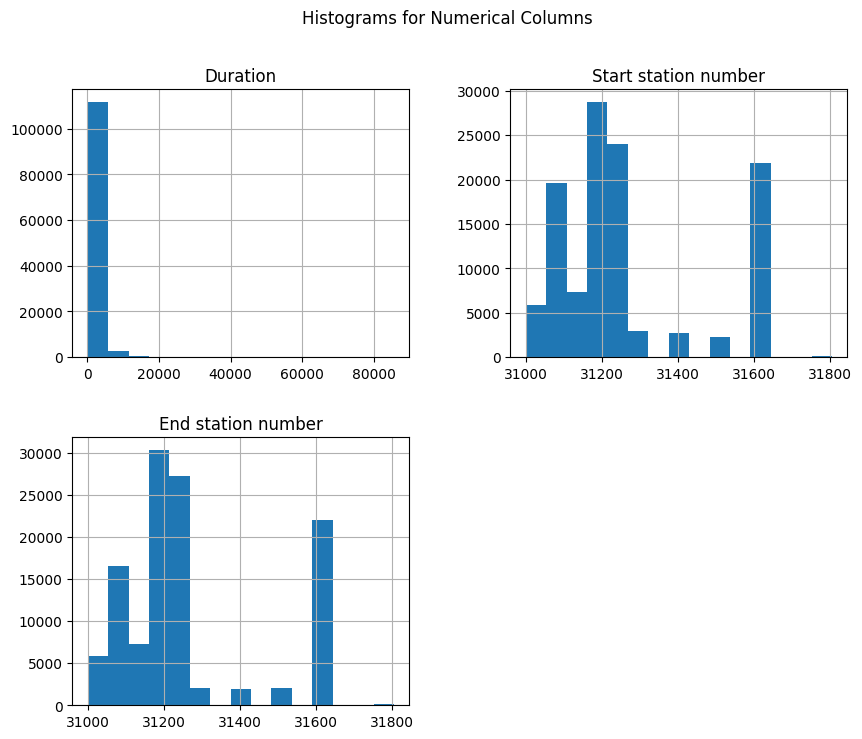

In [6]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
# plt.show()
plt.savefig(os.path.join(output_path, "trip_histograms.png"))

In [7]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]

Number of missing values in each column before filling:
Duration                0
Start date              0
End date                0
Start station number    0
Start station           0
End station number      0
End station             0
Bike number             0
Member type             0
dtype: int64


In [8]:
# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)

In [9]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")



Values used to fill columns with missing values:
Duration: 1254.6499563137452
Start date: 2010-10-17 14:36:24
End date: 2010-10-11 13:22:46
Start station number: 31266.213431144406
Start station: Massachusetts Ave & Dupont Circle NW
End station number: 31268.042250231407
End station: Massachusetts Ave & Dupont Circle NW
Bike number: W01091
Member type: Member


In [11]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

# Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list



Outliers Detected for Duration:
        Duration           Start date             End date  \
2           2690  2010-09-20 12:05:37  2010-09-20 12:50:27   
8           2496  2010-09-20 12:18:38  2010-09-20 13:00:15   
17          2988  2010-09-20 12:41:37  2010-09-20 13:31:25   
32          3044  2010-09-20 14:28:39  2010-09-20 15:19:23   
40          2228  2010-09-20 15:27:54  2010-09-20 16:05:03   
...          ...                  ...                  ...   
115447      3078  2010-12-31 18:12:51  2010-12-31 19:04:10   
115543      2757  2010-12-31 21:14:58  2010-12-31 22:00:56   
115588     16542  2010-12-31 23:16:16  2011-01-01 03:51:58   
115589      2368  2010-12-31 23:17:31  2010-12-31 23:56:59   
115596     51962  2010-12-31 23:49:05  2011-01-01 14:15:08   

        Start station number                  Start station  \
2                      31600                  5th & K St NW   
8                      31600                  5th & K St NW   
17                     31206     

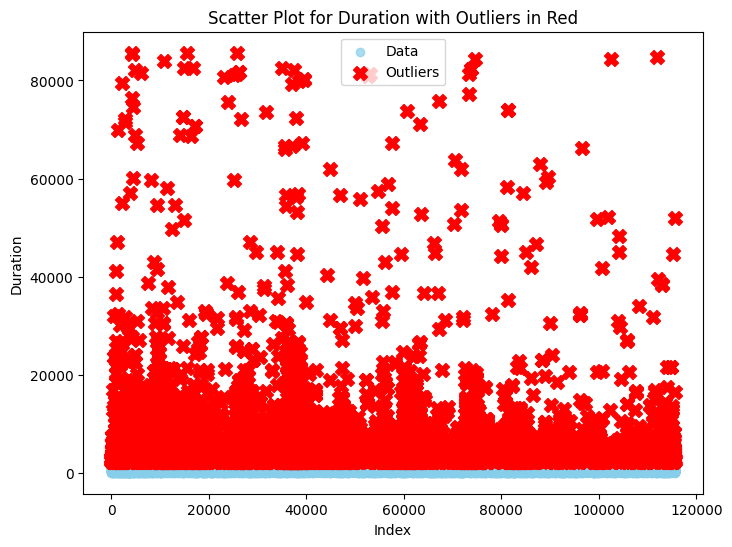

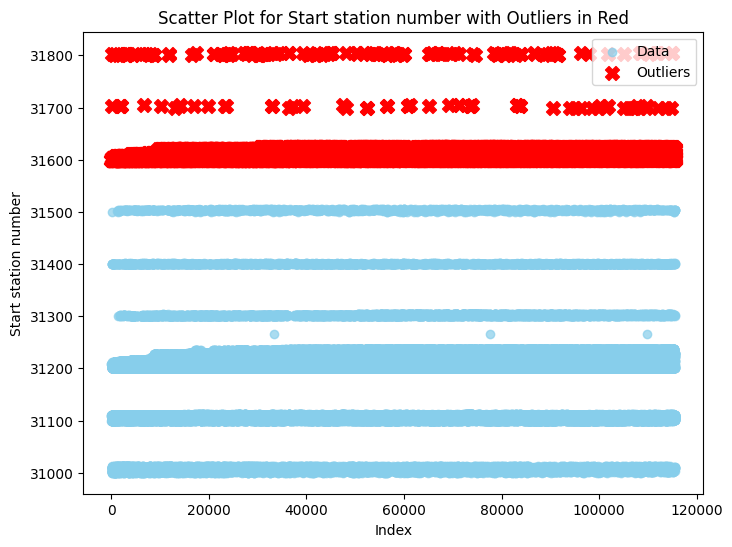

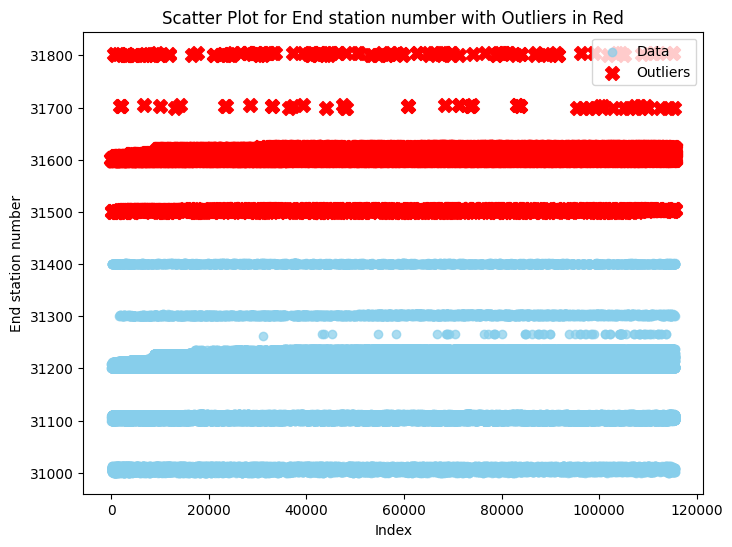

In [12]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    # plt.show()
    plot_filename = f"trip_scatter_{feature}.png"  # Use feature name in the file
    plt.savefig(os.path.join(output_path, plot_filename))

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)

In [ ]:
 # Visualize the original data with a pairplot (including outliers)
    sns.pairplot(data, hue='Member type', plot_kws={'alpha': 0.5})
    plt.suptitle("Pairplot of Features with Member type Class Labels (Including Outliers)", y=1.02)
    # plt.show()
    plt.savefig(os.path.join(output_path, "trip_outliers_member.png"))

In [14]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
  outliers = outliers_dict[feature]  # Get outliers for the current feature
  cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers

In [ ]:
# Visualize the cleaned data with a pairplot (after removing outliers)
    sns.pairplot(cleaned_data, hue='Member type', plot_kws={'alpha': 0.5})
    plt.suptitle("Pairplot of Features with Member type Class Labels (After Removing Outliers)", y=1.02)
    # plt.show()
    plt.savefig(os.path.join(output_path, "trip_removed_outliers_member.png"))

In [15]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['Member type'] = label_encoder.fit_transform(data['Member type'])

In [16]:
# Step 9: Handle non-numeric columns in X

# Convert categorical features to numeric using one-hot encoding or label encoding
# Here we use LabelEncoder for each categorical column (excluding the target 'Loan_Status')
for column in data.select_dtypes(include=['object']).columns:
    if column != 'Member type':  # Avoid encoding the target variable
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

In [17]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['Member type'])  # Features
y = data['Member type']  # Target variable

# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}


In [19]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)

In [20]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

In [21]:
# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

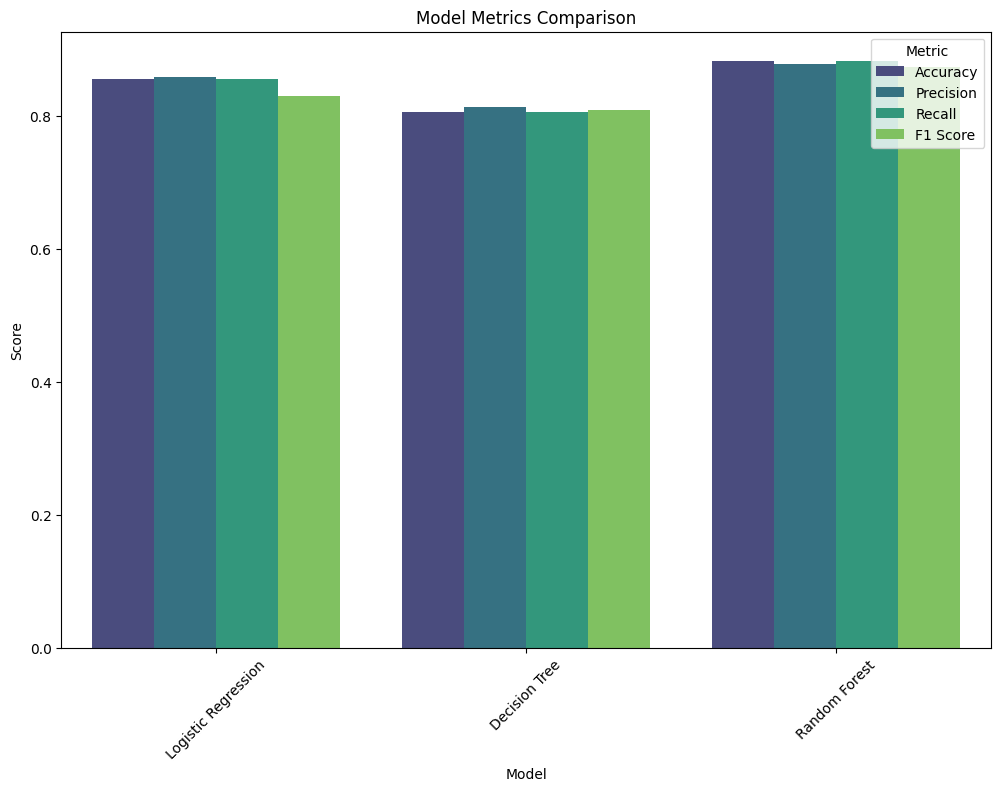

In [22]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
# plt.show()
plt.savefig(os.path.join(output_path, "trip_metrics.png"))


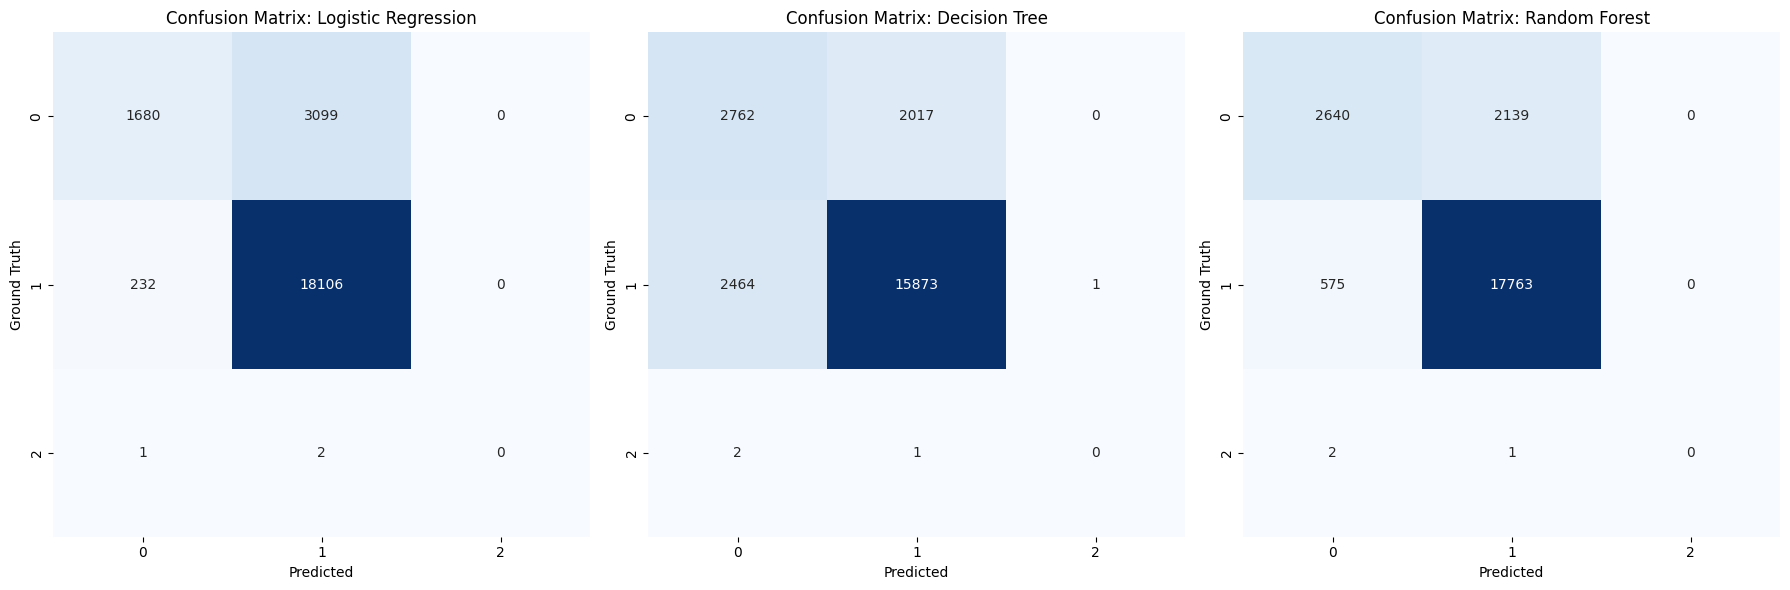

In [23]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(output_path, "trip_metrix.png"))

In [24]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.35      0.50      4779
           1       0.85      0.99      0.92     18338
           2       0.00      0.00      0.00         3

    accuracy                           0.86     23120
   macro avg       0.58      0.45      0.47     23120
weighted avg       0.86      0.86      0.83     23120


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.53      0.58      0.55      4779
           1       0.89      0.87      0.88     18338
           2       0.00      0.00      0.00         3

    accuracy                           0.81     23120
   macro avg       0.47      0.48      0.48     23120
weighted avg       0.81      0.81      0.81     23120


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.55      0.66      47